<h1> Thresholding </h1> 

Its the binarization of an image: we seek to convert a grayscale image to a binary image, where the pixels are either 0 or 255.

A simple thresholding example would be selecting a threshold value T, and then setting all pixel intensities less than T to zero, and all pixel values greater than T to 255. In this way, we are able to create a binary representation of the image.

Normally, we use thresholding to focus on objects or areas of particular interest in an image. In the examples in the lesson below, we will be using thresholding to detect coins in images, segment the pieces of the OpenCV logo, and separate license plate letters and characters from the license plate itself.

# Simple Thresholding

It requires human intervention. We must specify a threshold value T. All pixel intensities below T are set to 255. And all pixel intensities greater than T are set to 0.

We could also apply the inverse of this binarization by setting all pixels greater than T to 255 and all pixel intensities below T to 0.

In [1]:
# import the necessary packages
import cv2
from matplotlib import pyplot as plt

In [2]:
# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread("coins01.png")

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

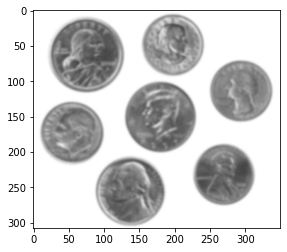

In [3]:
# The GaussianBlur helps remove some of the undesired high frequency edges
#  in the image and allow us to obtain a more “clean” segmentation.
blurred = cv2.GaussianBlur(gray, (7, 7), 0)

plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
plt.show()

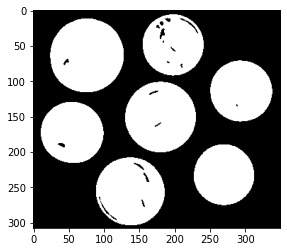

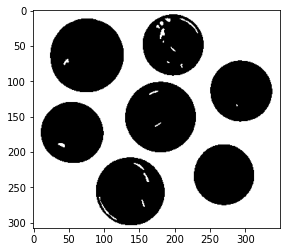

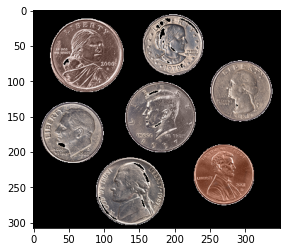

In [4]:
# cv2.threshold:  (with INV flag on)
#
# if pixel > my_threshold       pixel = 0 (BLACK)
# else                          pixel = desired_value (255 = WHITE)

my_threshold = 200 # user defined value
desired_value = 255 

(T, threshInv) = cv2.threshold(blurred, my_threshold, desired_value, cv2.THRESH_BINARY_INV)

plt.imshow(cv2.cvtColor(threshInv, cv2.COLOR_BGR2RGB))
plt.show()

# using normal thresholding (rather than inverse thresholding),
# we can change the last argument in the function to make the coins
# black rather than white.
(T, thresh) = cv2.threshold(blurred, my_threshold, desired_value, cv2.THRESH_BINARY)

plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.show()

# finally, we can visualize only the masked regions in the image
plt.imshow(cv2.cvtColor(cv2.bitwise_and(image, image, mask=threshInv), cv2.COLOR_BGR2RGB))
plt.show()


# Otsu's Method

Its an automatic method to comput an optimal value of T for a given image. It assumes the image contains two classes of pixels: the background and the foreground. Furthermore, Otsu’s method makes the assumption that the grayscale histogram of our pixel intensities of our image is bi-modal, which simply means that the histogram is two peaks.


Based on the grayscale histogram, Otsu’s method then computes an optimal threshold value T such that the variance between the background and foreground peaks is minimal.

However, Otsu’s method has no a priori knowledge of what pixels belong to the foreground and which pixels belong to the background — it’s simply trying to optimally separate the peaks of the histogram.

It’s also important to note that Otsu’s method is an example of global thresholding — implying that a single value of T is computed for the entire image. In some cases, having a single value of T for an entire image is perfectly acceptable — but in other cases, this can lead to sub-par results, as we’ll see when we try to segment license plate characters and letters from the license plate itself in the next section.

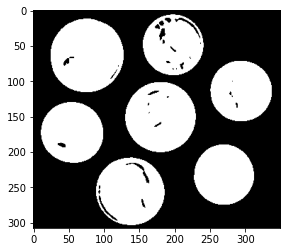


 Otsu's thresholding value: 191.0



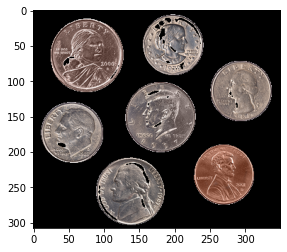

In [5]:
my_threshold = 0      # if 0, then the function calculates it automatically
desired_value = 255 

# Apply Otsu's automatic thresholding 
(T, threshInv) = cv2.threshold(blurred, my_threshold, desired_value,	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

plt.imshow(cv2.cvtColor( threshInv, cv2.COLOR_BGR2RGB))
plt.show()

print("\n Otsu's thresholding value: {}\n".format(T))

# finally, we can visualize only the masked regions in the image
plt.imshow(cv2.cvtColor(   cv2.bitwise_and(image, image, mask=threshInv), cv2.COLOR_BGR2RGB))
plt.show()


# Adaptive Thresholding

One of the downsides of using simple thresholding methods is that we need to manually supply our threshold value T. 

To aid us in automatically determining the value of $T$, we leveraged Otsu’s method. And while Otsu’s method can save us a lot of time playing the “guess and checking” game, we are left with only a single value of $T$ to threshold the entire image.

For simple images with controlled lighting conditions, this usually isn’t a problem. But for situations when the lighting is non-uniform across the image, having only a single value of T can seriously hurt our thresholding performance.

In order to overcome this problem, we can use adaptive thresholding, which considers small neighbors of pixels and then finds an optimal threshold value T for each neighbor. This method allows us to handle cases where there may be dramatic ranges of pixel intensities and the optimal value of T may change for different parts of the image.

In adaptive thresholding, sometimes called local thresholding, our goal is to statistically examine the pixel intensity values in the neighborhood of a given pixel p.
 

*The general assumption that underlies all adaptive and local thresholding methods is that smaller regions of an image are more likely to have approximately uniform illumination. This implies that local regions of an image will have similar lighting, as opposed to the image as a whole, which may have dramatically different lighting for each region.* bold text


However, choosing the size of the pixel neighborhood for local thresholding is absolutely crucial.

The neighborhood must be large enough to cover sufficient background and foreground pixels, otherwise the value of T will be more or less irrelevant.

But if we make our neighborhood value too large, then we completely violate the assumption that local regions of an image will have approximately uniform illumination. Again, if we supply a very large neighborhood, then our results will look very similar to global thresholding using the simple thresholding or Otsu’s methods.

In practice, tuning the neighborhood size is (usually) not that hard of a problem. You’ll often find that there is a broad range of neighborhood sizes that provide you with adequate results — it’s not like finding an optimal value of T that could make or break your thresholding output.

So as I mentioned above, our goal in adaptive thresholding is to statistically examine local regions of our image and determine an optimal value of T for each region — which begs the question: Which statistic do we use to compute the threshold value $$ for each region?

It is common practice to use either the arithmetic mean or the Gaussian mean of the pixel intensities in each region (other methods do exist, but the arithmetic mean and the Gaussian mean are by far the most popular).

In the arithmetic mean, each pixel in the neighborhood contributes equally to computing T. And in the Gaussian mean, pixel values farther away from the (x, y)-coordinate center of the region contribute less to the overall calculation of $T$.

The general formula to compute $T$ is thus:

$ T = mean( I_L ) -C $ 

where the $mean$ is either the arithmetic or Gaussian mean, $I_{L}$ is the local sub-region of the image $I$, and $C$ is some constant which we can use to fine tune the threshold value $T$.

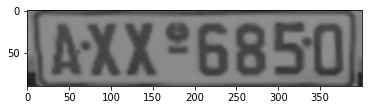

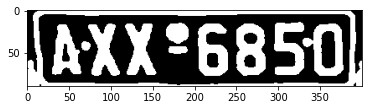


 Otsu's thresholding value: 105.0



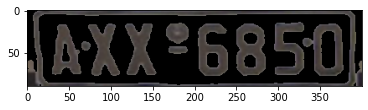

In [7]:
from skimage.filters import threshold_local

# load the image, convert it to grayscale, and blur it slightly
image = cv2.imread("license_plate.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# The GaussianBlur helps remove some of the undesired high frequency edges
#  in the image and allow us to obtain a more “clean” segmentation.
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

plt.imshow(cv2.cvtColor( blurred, cv2.COLOR_BGR2RGB))
plt.show()

my_threshold = 0      # if 0, then the function calculates it automatically
desired_value = 255 

# Apply Otsu's automatic thresholding 
(T, threshInv) = cv2.threshold(blurred, my_threshold, desired_value,	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

plt.imshow(cv2.cvtColor( threshInv, cv2.COLOR_BGR2RGB))
plt.show()


print("\n Otsu's thresholding value: {}\n".format(T))

# finally, we can visualize only the masked regions in the image
plt.imshow(cv2.cvtColor( cv2.bitwise_and(image, image, mask=threshInv), cv2.COLOR_BGR2RGB))
plt.show()


 OpenCV Mean Thresh



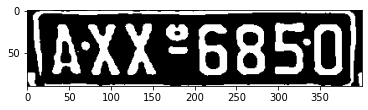


 scikit-image Mean Thresh



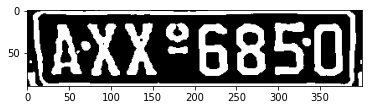

In [8]:
my_threshold = 255      # if 0, then the function calculates it automatically
#desired_value = 255 

# we’ll be computing the mean grayscale pixel intensity value of each
# 25x25 sub-region in the image to compute our threshold value T.

px_neighborhood_size = 29  

c_param = 15 # fine tune parameter "c"


# instead of manually specifying the threshold value, we can use adaptive
# thresholding to examine neighborhoods of pixels and adaptively threshold
# each neighborhood -- in this example, we'll calculate the mean value
# of the neighborhood area of 25 pixels and threshold based on that value;
# finally, our constant C is subtracted from the mean calculation (in this
# case 15)
thresh = cv2.adaptiveThreshold(blurred, 
                               my_threshold,	
                               cv2.ADAPTIVE_THRESH_MEAN_C, 
                               cv2.THRESH_BINARY_INV, 
                               px_neighborhood_size, 
                               c_param)

print("\n OpenCV Mean Thresh\n")
plt.imshow(cv2.cvtColor( thresh, cv2.COLOR_BGR2RGB))
plt.show()

# personally, I prefer the scikit-image adaptive thresholding:
T = threshold_local(blurred, px_neighborhood_size, offset=5, method="gaussian")
thresh = (blurred < T).astype("uint8") * 255

print("\n scikit-image Mean Thresh\n")
plt.imshow(cv2.cvtColor( thresh, cv2.COLOR_BGR2RGB))
plt.show()
